In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from samplers import *
import matplotlib.pyplot as plt

In [88]:
#initialize samplers
p_dist = distribution3()
q_dist = distribution3()
a_dist = uniform_1d()

In [101]:
class MLP(nn.Module):
   
    def __init__(self):
        
        super(MLP, self).__init__()
       
        self.layers = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x
    
class MLP_2d(nn.Module):
   
    def __init__(self):
        
        super(MLP_2d, self).__init__()
       
        self.layers = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):

        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x
    


## Problem 1.1

In [57]:
def loss_JS(D_x,D_y):
    return np.log(2) + (1/2)*(D_x.log().mean()) + (1/2)*((1-D_y).log().mean())

In [60]:
#PROBLEM 1.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MLP().double()
model = model.to(device)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

mean_train_losses = []
epochs = 15
num_minibatch = 100

for epoch in range(epochs):
    
    model.train()
    train_losses = []
        
    for i in range(num_minibatch):
        
        optimizer.zero_grad()
        
        #forward for x (normal 0 std 1)
        x_outputs = model(torch.tensor(next(p_dist)).to(device))
        #forward for y (normal 10 std 1)
        y_outputs = model(torch.tensor(next(q_dist)).to(device))
        
        loss = -loss_JS(x_outputs, y_outputs)
        
        loss.backward()
#         clip = 1
#         torch.nn.utils.clip_grad_norm(model.parameters(),clip)
        optimizer.step()
        
        train_losses.append(loss.item())
            
    mean_train_losses.append(np.mean(train_losses))
    
    #early stop
#     if (mean_train_losses[-1]<-10): 
#         break
    
    print('epoch : {}, train loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses)))

epoch : 1, train loss : 0.0001
epoch : 2, train loss : 0.0000
epoch : 3, train loss : 0.0000
epoch : 4, train loss : 0.0000
epoch : 5, train loss : 0.0000
epoch : 6, train loss : 0.0000
epoch : 7, train loss : 0.0000
epoch : 8, train loss : 0.0000
epoch : 9, train loss : 0.0000
epoch : 10, train loss : 0.0000
epoch : 11, train loss : 0.0000
epoch : 12, train loss : 0.0000
epoch : 13, train loss : 0.0000
epoch : 14, train loss : 0.0000
epoch : 15, train loss : -0.0000


In [41]:
#test
x= torch.tensor(next(p_dist)).to(device)
y= torch.tensor(next(q_dist)+10).to(device)

model.eval()

print(model.forward(x).mean())
print(model.forward(y).mean())


tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(6.3506e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward1>)


## Problem 1.2

In [42]:
def loss_WD(D_x,D_y,grad_z,mylambda):
    return D_x.mean() - D_y.mean() - (mylambda * ((torch.norm(grad_z)-1).pow(2).mean()))

In [44]:
#PROBLEM 1.2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MLP().double()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

mean_train_losses = []
epochs = 15
num_minibatch = 100

for epoch in range(epochs):
    
    model.train()
    train_losses = []
        
    for i in range(num_minibatch):
        
        optimizer.zero_grad()
        x = torch.tensor(next(p_dist)).to(device)
        y= torch.tensor(next(q_dist) + 10).to(device)
        #forward for x (normal 0 std 1)
        x_outputs = model(x)
        #forward for y (normal 10 std 1)
        y_outputs = model(y)
        
        a = torch.tensor(next(a_dist)).to(device)
        z = Variable(a*x +(1-a)*y,requires_grad=True)
        
        z_outputs= model(z)
        z_outputs_mean = z_outputs.mean()
        z_outputs_mean.backward(retain_graph=True)
        
        grad_z = z.grad
        optimizer.zero_grad()
        
        loss = -loss_WD(x_outputs, y_outputs, grad_z,10)
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
            
    mean_train_losses.append(np.mean(train_losses))
    
    #early stop
#     if (mean_train_losses[-1]<-3): 
#         break
    
    print('epoch : {}, train loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses)))

epoch : 1, train loss : 9.3321
epoch : 2, train loss : 8.8727
epoch : 3, train loss : 8.8469
epoch : 4, train loss : 8.8323
epoch : 5, train loss : 8.8183
epoch : 6, train loss : 8.8084
epoch : 7, train loss : 8.7941
epoch : 8, train loss : 8.7747
epoch : 9, train loss : 8.7699
epoch : 10, train loss : 8.7649
epoch : 11, train loss : 8.7570
epoch : 12, train loss : 8.7532
epoch : 13, train loss : 8.7489
epoch : 14, train loss : 8.7447
epoch : 15, train loss : 8.7423


In [46]:
#test
x= torch.tensor(next(p_dist)).to(device)
y= torch.tensor(next(q_dist) + 10).to(device)

model.eval()

print(model.forward(x).mean())
print(model.forward(y).mean())


tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward1>)
tensor(9.8889e-06, device='cuda:0', dtype=torch.float64,
       grad_fn=<MeanBackward1>)


## Problem 1.3

In [61]:
def get_JS(p_dist,q_dist):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = MLP_2d().double()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    mean_train_losses = []
    epochs = 10
    num_minibatch = 100

    for epoch in range(epochs):

        model.train()
        train_losses = []

        for i in range(num_minibatch):

            optimizer.zero_grad()

            #forward for x 
            x_outputs = model(torch.tensor(next(p_dist)).to(device))
            #forward for y 
            y_outputs = model(torch.tensor(next(q_dist)).to(device))

            loss = -loss_JS(x_outputs, y_outputs)

            loss.backward()
            
            optimizer.step()

            train_losses.append(loss.item())

        mean_train_losses.append(np.mean(train_losses))

        #early stop
        if (mean_train_losses[-1]<-10): 
            break

#         print('epoch : {}, train loss : {:.4f}'\
#              .format(epoch+1, np.mean(train_losses)))
        
    #forward for x 
    x_outputs = model(torch.tensor(next(p_dist)).to(device))
    #forward for y 
    y_outputs = model(torch.tensor(next(q_dist)).to(device))

    loss = loss_JS(x_outputs, y_outputs)
    
    return loss

In [67]:
def get_WD(p_dist,q_dist):
    #PROBLEM 1.2
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = MLP_2d().double()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    mean_train_losses = []
    epochs = 10
    num_minibatch = 100

    for epoch in range(epochs):

        model.train()
        train_losses = []

        for i in range(num_minibatch):

            optimizer.zero_grad()
            x = torch.tensor(next(p_dist)).to(device)
            y= torch.tensor(next(q_dist)).to(device)
            #forward for x (normal 0 std 1)
            x_outputs = model(x)
            #forward for y (normal 10 std 1)
            y_outputs = model(y)

            a = torch.tensor(next(a_dist)).to(device)
            z = Variable(a*x +(1-a)*y,requires_grad=True)

            z_outputs= model(z)
            z_outputs_mean = z_outputs.mean()
            z_outputs_mean.backward(retain_graph=True)

            grad_z = z.grad
            optimizer.zero_grad()

            loss = -loss_WD(x_outputs, y_outputs, grad_z,10)
            loss.backward()

            optimizer.step()

            train_losses.append(loss.item())

        mean_train_losses.append(np.mean(train_losses))

        #early stop
    #     if (mean_train_losses[-1]<-3): 
    #         break

#         print('epoch : {}, train loss : {:.4f}'\
#              .format(epoch+1, np.mean(train_losses)))
        
        
    x = torch.tensor(next(p_dist)).to(device)
    y= torch.tensor(next(q_dist)).to(device)
    #forward for x 
    x_outputs = model(x).to(device)
    #forward for y 
    y_outputs = model(y).to(device)
    
    a = torch.tensor(next(a_dist)).to(device)
    z = Variable(a*x +(1-a)*y,requires_grad=True)

    z_outputs= model(z)
    z_outputs_mean = z_outputs.mean()
    z_outputs_mean.backward(retain_graph=True)

    grad_z = z.grad
    optimizer.zero_grad()

    loss = loss_WD(x_outputs, y_outputs, grad_z,10)
    
    return loss

In [64]:
JS_list = []
theta_list = np.linspace(-1, 1, num=21)

for theta in theta_list:
    print(theta)
    p_dist = distribution1(0, batch_size=512)
    q_dist = distribution1(theta, batch_size=512)
    JS_list.append(get_JS(p_dist,q_dist))
    print(JS_list[-1])
    

-1.0
tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-0.9
tensor(0.6930, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-0.8
tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-0.7
tensor(0.6930, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-0.6
tensor(0.6930, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-0.5
tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-0.3999999999999999
tensor(0.6930, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-0.29999999999999993
tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-0.19999999999999996
tensor(0.6931, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
-0.09999999999999998
tensor(0.6927, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
0.0
tensor(3.1143e-05, device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
0.10000000000000009
tenso

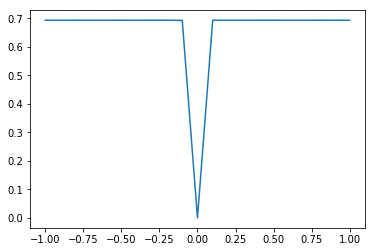

In [65]:
plt.plot(theta_list,JS_list)

In [68]:
WD_list = []
theta_list = np.linspace(-1, 1, num=21)

for theta in theta_list:
    print(theta)
    p_dist = distribution1(0, batch_size=512)
    q_dist = distribution1(theta, batch_size=512)
    WD_list.append(get_WD(p_dist,q_dist))
    print(WD_list[-1])

-1.0
tensor(-7.3336, device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)
-0.9
tensor(-6.8115, device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)
-0.8
tensor(-7.0296, device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)
-0.7
tensor(-6.4954, device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)
-0.6
tensor(-6.2065, device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)
-0.5
tensor(-6.1797, device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)
-0.3999999999999999
tensor(-5.1215, device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)
-0.29999999999999993
tensor(-4.3521, device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)
-0.19999999999999996
tensor(-2.2984, device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)
-0.09999999999999998
tensor(0.3202, device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)
0.0
tensor(-9.9982, device='cuda:0', dtype=torch.float64, grad_fn=<SubBackward0>)
0.10000000000000009
tensor

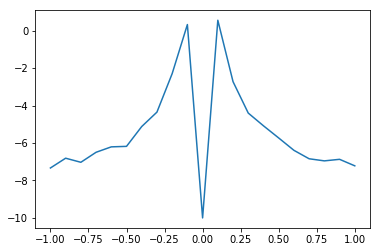

In [73]:
plt.plot(theta_list,WD_list)

## Problem 1.4

In [99]:
def loss_density(D_x,D_y):
    return(D_x.log().mean()) + ((1-D_y).log().mean())

In [102]:
#PROBLEM 1.4
f0 = distribution3()
f1 = distribution4(batch_size=512)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MLP().double()
model = model.to(device)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

mean_train_losses = []
epochs = 15
num_minibatch = 100

for epoch in range(epochs):
    
    model.train()
    train_losses = []
        
    for i in range(num_minibatch):
        
        optimizer.zero_grad()
        
        #forward for x (normal 0 std 1)
        x_outputs = model(torch.tensor(next(f1)).to(device))
        #forward for y (normal 10 std 1)
        y_outputs = model(torch.tensor(next(f0)).to(device))
        
        loss = -loss_density(x_outputs, y_outputs)
        
        loss.backward()

        optimizer.step()
        
        train_losses.append(loss.item())
            
    mean_train_losses.append(np.mean(train_losses))
    
    print('epoch : {}, train loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses)))

epoch : 1, train loss : 1.2596
epoch : 2, train loss : 1.2165
epoch : 3, train loss : 1.2114
epoch : 4, train loss : 1.2110
epoch : 5, train loss : 1.2102
epoch : 6, train loss : 1.2124
epoch : 7, train loss : 1.2169
epoch : 8, train loss : 1.2116
epoch : 9, train loss : 1.2150
epoch : 10, train loss : 1.2094
epoch : 11, train loss : 1.2157
epoch : 12, train loss : 1.2140
epoch : 13, train loss : 1.2125
epoch : 14, train loss : 1.2086
epoch : 15, train loss : 1.2144


In [197]:
#test
xx_tensor= torch.tensor(np.linspace(-5,5,1000)).to(device)
d_xx = np.array(model.forward(xx_tensor).detach().cpu()).reshape(-1)
xx = np.linspace(-5,5,1000)

Text(0.5, 1.0, 'Estimated vs True')

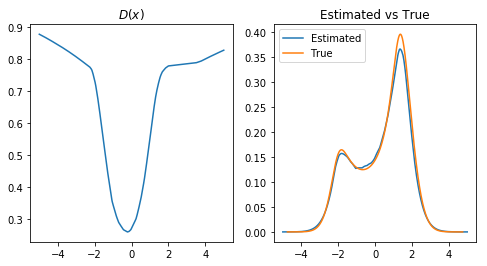

In [198]:

from __future__ import print_function
import numpy as np
import torch 
import matplotlib.pyplot as plt


############### plotting things
############### (1) plot the output of your trained discriminator 
############### (2) plot the estimated density contrasted with the true density

f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
r = d_xx # evaluate xx using your discriminator; replace xx with the output
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(xx,r)
plt.title(r'$D(x)$')

estimate = (N(xx)*d_xx)/(1-d_xx) # estimate the density of distribution4 (on xx) using the discriminator; 
                                # replace "np.ones_like(xx)*0." with your estimate
plt.subplot(1,2,2)
plt.plot(xx,estimate)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')

